# Boundary Value Problems

So far, we've looked at *Initial Value Problems* (IVPs), where all conditions are specified at a single starting time $t_0$. We'll now explore *Boundary Value Problems* (BVPs), which are common in physics and engineering. 

In a BVP, the conditions are specified at *different* points, typically the endpoints (or boundaries) of a domain. Since the independent variable often represents space, we'll use $x$ instead of $t$.

A model BVP is the 1D Poisson equation with Dirichlet conditions (fixed values) at the endpoints:

$$
\begin{align*}
u''(x) &= f(x), \quad 0<x<1 \\
u(0) &= \alpha \\
u(1) &= \beta
\end{align*}
$$

Unlike an IVP, we can't just "march" forward from one point, because we have a condition at the end, $u(1)=\beta$, that we have to satisfy. 

### The Finite Difference Method

A classic approach to solving BVPs is the *finite difference method*. The core idea is to replace derivatives with algebraic approximations at a set of discrete grid points.

1.  **Create a Grid:** We discretize the domain $[0, 1]$ into $n+1$ equal intervals. This creates $n$ *interior* points and 2 boundary points, for $n+2$ total points. The grid spacing is $h = 1/(n+1)$, and the grid points are $x_j = jh$ for $j=0, 1, \ldots, n+1$.

2.  **Approximate the Solution:** We want to find an approximation $u_j \approx u(x_j)$ at each of these grid points. We already know $u_0 = \alpha$ and $u_{n+1} = \beta$ from the boundary conditions. Our goal is to find the $n$ interior values $u_1, u_2, \ldots, u_n$.

3.  **Replace Derivatives:** We replace the $u''(x)$ term with a *centered finite difference* approximation, which is second-order accurate:

$$
u''(x_j) \approx \frac{u(x_j+h) - 2u(x_j) + u(x_j-h)}{h^2} \approx \frac{u_{j+1} - 2u_j + u_{j-1}}{h^2}
$$

By substituting this into our ODE $u''(x_j) = f(x_j)$, we get an algebraic equation for each *interior* grid point $j=1, \ldots, n$:

$$
\frac{u_{j+1} - 2u_j + u_{j-1}}{h^2} = f(x_j)
$$

Rearranging this gives us a large linear equation for each $u_j$:

$$
u_{j-1} - 2u_j + u_{j+1} = h^2 f(x_j), \quad \text{for } j = 1,\ldots, n
$$

### Building the Linear System

This set of $n$ equations for the $n$ unknown values $(u_1, \ldots, u_n)$ forms a linear system $Au=b$. Let's see how the boundary conditions $u_0 = \alpha$ and $u_{n+1} = \beta$ fit in.

* **For $j=1$ (first row):** $u_0 - 2u_1 + u_2 = h^2 f(x_1)$. Since $u_0 = \alpha$, we move this known value to the right side: 
    $$-2u_1 + u_2 = h^2 f(x_1) - \alpha$$

* **For $j=n$ (last row):** $u_{n-1} - 2u_n + u_{n+1} = h^2 f(x_n)$. Since $u_{n+1} = \beta$, we move it to the right side:
    $$u_{n-1} - 2u_n = h^2 f(x_n) - \beta$$

This results in the $n \times n$ tridiagonal system $Au=b$ where $u = [u_1, u_2, \ldots, u_n]^T$ and:

$$
A=
\begin{bmatrix}
-2 & 1 & & & \\
1 & -2 & 1 & & \\
 & 1 & -2 & \ddots & \\
 & & \ddots & \ddots & 1 \\
 & & & 1 & -2
\end{bmatrix}
\quad u=
\begin{bmatrix}
u_1 \\ u_2 \\ \vdots \\ u_{n-1} \\ u_n
\end{bmatrix}
\quad b=
\begin{bmatrix}
h^2f(x_1) - \alpha \\
h^2f(x_2) \\
\vdots \\
h^2f(x_{n-1}) \\
h^2f(x_n)-\beta
\end{bmatrix}
$$

## Example: Solving a 1D BVP

Let's solve the following boundary value problem:

$$
\begin{align*}
u''(x) &= 10e^{2x}\sin(2\pi x), \quad 0<x<1 \\
u(0) &= -1 \\
u(1) &= 1
\end{align*}
$$

We'll solve this using $n=49$ interior points. This means our grid spacing will be $h = 1/(49+1) = 1/50 = 0.02$. We are solving for the 49 unknown values $u_1, u_2, \ldots, u_{49}$.

In [1]:
using Plots, LinearAlgebra

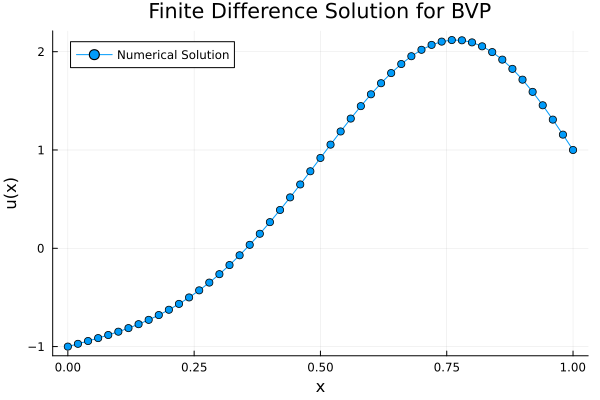

In [2]:
# 1. Set up the grid parameters
n = 49                      # Number of *interior* grid points
h = 1 / (n+1)               # Grid spacing (h = 1/50 = 0.02)

# Define the boundary conditions
alpha = -1.0  # u(0)
beta = 1.0   # u(1)

# Create a vector 'x_interior' for the *interior* points x_1, ..., x_n
x_interior = h*(1:n)

# Define the right-hand side function f(x) from the ODE
f(x) = 10exp(2x)*sin(2π*x)

# 2. Construct the finite difference matrix A
# This is an n x n matrix for the n interior points.
# It has -2 on the diagonal and 1 on the super- and sub-diagonals.
# SymTridiagonal is an efficient way to store this. 
# It takes the diagonal (n elements) and the off-diagonal (n-1 elements).
A = SymTridiagonal(-2*ones(n), ones(n-1))

# 3. Construct the right-hand side vector b
# Start with b_j = h^2 * f(x_j) for all interior j
b = h^2 * f.(x_interior)

# 4. Modify the 'b' vector to account for boundary conditions
# For j=1 (the first row): -2u_1 + u_2 = h^2*f(x_1) - u_0
# We subtract alpha (which is u_0) from the first element of b
b[1] -= alpha

# For j=n (the last row): u_{n-1} - 2u_n = h^2*f(x_n) - u_{n+1}
# We subtract beta (which is u_{n+1}) from the last element of b
b[end] -= beta

# 5. Solve the linear system Au = b
# The backslash operator (\) is a highly efficient solver for linear systems.
# 'u_interior' will be a vector of the n solution values [u_1, ..., u_n]
u_interior = A \ b

# 6. Plot the full solution
# To plot the complete solution, we'll combine the boundary points
# with our computed interior solution.

# Create the full x-grid: [x_0, x_1, ..., x_n, x_{n+1}]
# (This is equivalent to 0:h:1)
x_full = [0; x_interior; 1]

# Create the full solution vector: [u_0, u_1, ..., u_n, u_{n+1}]
# We use [alpha; u_interior; beta] to concatenate them
u_full = [alpha; u_interior; beta]

plot(x_full, u_full, markershape=:circle,
     title="Finite Difference Solution for BVP",
     xlabel="x", ylabel="u(x)", label="Numerical Solution")